In [1]:
from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

In [2]:
PATH = './'
TRAIN = './airbus-ship-detection/train_v2/'
TEST = './airbus-ship-detection/test_v2/'
SEGMENTATION = './airbus-ship-detection/train_ship_segmentations_v2.csv'
exclude_list = ['6384c3e78.jpg'] #corrupted image

In [3]:
nw = 12   #number of workers for data loader
arch = resnet34 #specify target architecture

In [4]:
train_names = [f for f in os.listdir(TRAIN)]
test_names = [f for f in os.listdir(TEST)]
for el in exclude_list:
    if(el in train_names): train_names.remove(el)
    if(el in test_names): test_names.remove(el)
#5% of data in the validation set is sufficient for model evaluation
tr_n, val_n = train_test_split(train_names, test_size=0.05, random_state=42)

In [5]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.segmentation_df = pd.read_csv(SEGMENTATION).set_index('ImageId')
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_image(os.path.join(self.path, self.fnames[i]))
        if self.sz == 768: return img 
        else: return cv2.resize(img, (self.sz, self.sz))
    
    def get_y(self, i):
        if(self.path == TEST): return 0
        masks = self.segmentation_df.loc[self.fnames[i]]['EncodedPixels']
        if(type(masks) == float): return 0 #NAN - no ship 
        else: return 1
    
    def get_c(self): return 2 #number of classes

In [6]:
def get_data(sz,bs):
    #data augmentation
    aug_tfms = [RandomRotate(20, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO)]
    tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
#     md.is_multi = False
    return md

In [7]:
sz = 256 #image size
bs = 64  #batch size

md = get_data(sz,bs)

In [8]:
learn = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
learn.opt_fn = optim.Adam

 66%|██████▌   | 1880/2858 [09:53<04:44,  3.44it/s, loss=0.875]

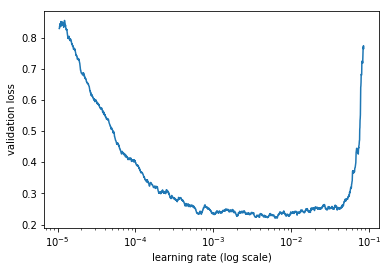

In [28]:
learn.lr_find()
learn.sched.plot()

In [29]:
learn.fit(2e-3, 1)

epoch      trn_loss   val_loss   accuracy                      
    0      0.193137   0.139318   0.945472  


[0.1393184067335523, 0.945471541387291]

In [30]:
learn.unfreeze()
lr=np.array([1e-4,5e-4,2e-3])

In [31]:
learn.fit(lr, 1, cycle_len=2, use_clr=(20,8))

epoch      trn_loss   val_loss   accuracy                       
    0      0.112681   0.082758   0.970399  
    1      0.088984   0.061518   0.977254                       


[0.06151825555464416, 0.9772538430075651]

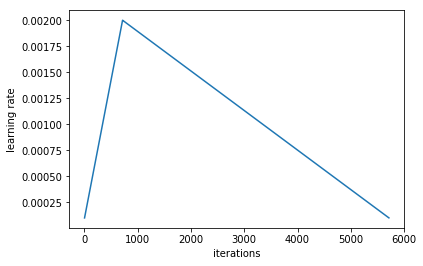

In [32]:
learn.sched.plot_lr()

In [33]:
learn.save('Resnet34_lable_256_1')

In [34]:
log_preds,y = learn.predict_with_targs(is_test=True)
probs = np.exp(log_preds)[:,1]
pred = (probs > 0.5).astype(int)

In [35]:
df = pd.DataFrame({'id':test_names, 'p_ship':probs})
df.to_csv('ship_detection.csv', header=True, index=False)

In [36]:
sz = 384 #image size
bs = 32  #batch size

md = get_data(sz,bs)
learn = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
learn.opt_fn = optim.Adam
learn.unfreeze()
lr=np.array([1e-4,5e-4,2e-3])